# Interactive maps with geopandas 

Gegeven een shape file kunnen we met geopandas een interactieve plot maken en daar ook weer punten op zetten. 

Zie [Geopandas explore ](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html)

Benodigde extra packages als we op colab willen runnen

In [ ]:
!pip install geopandas
!pip install matplotlib mapclassify pyproj
!pip install folium -U

In [ ]:
from urllib.request import urlopen
import json
import plotly.express as px
import pandas as pd
import geopandas as gpd
import folium
import json

from pyproj import CRS

import plotly.express as px

## buurt kaarten shape files van CBS

Zie [CBS data](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021)

In [ ]:
!wget https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip
!unzip wijkbuurtkaart_2021_v1.zip

--2022-01-01 15:29:28--  https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip
Resolving www.cbs.nl (www.cbs.nl)... 40.118.80.223
Connecting to www.cbs.nl (www.cbs.nl)|40.118.80.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184908185 (176M) [application/x-zip-compressed]
Saving to: ‘wijkbuurtkaart_2021_v1.zip’

wijkbuurtkaart_2021 100%[===================>] 176.34M   120MB/s    in 1.5s    

2022-01-01 15:29:29 (120 MB/s) - ‘wijkbuurtkaart_2021_v1.zip’ saved [184908185/184908185]

Archive:  wijkbuurtkaart_2021_v1.zip
 extracting: WijkBuurtkaart_2021_v1/buurt_2021_v1.CPG  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.dbf  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.prj  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.sbn  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.sbx  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.shp  
  inflating: WijkBuurtkaart_2021_v1/buurt_2021_v1.s

In [ ]:
####  Laad de CBS buurt shape file en converteer naar juiste coordinaatsysteem
####  heel nederland is te groot om goed te plotten.
####  focus op Amsterdam en de buurten met meer dan 200 inwoners

fp = "WijkBuurtkaart_2021_v1/buurt_2021_v1.shx"
amsterdam = (
    gpd.read_file(fp)
    .to_crs(CRS.from_epsg(4326))
    .query('GM_NAAM =="Amsterdam" ')
    .query('AANT_INW > 200')
    .dropna()
)
amsterdam.sample(3)

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_ONGEHUWD,P_GEHUWD,P_GESCHEID,P_VERWEDUW,AANTAL_HH,P_EENP_HH,P_HH_Z_K,P_HH_M_K,GEM_HH_GR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
4303,BU03633702,Bosleeuw,WK036337,GM0363,Amsterdam,1,NEE,1055,1,6215,1,16722,5700,2745,2955,15,16,39,22,9,65,26,7,2,2915,50,23,27,1.9,17,52,20,0,4,16,12,34,34,0,2021BU03633702,2021,2547.193938,342707.574557,"POLYGON ((4.84568 52.38517, 4.84619 52.38516, ..."
4335,BU03634600,Valeriusbuurt Oost,WK036346,GM0363,Amsterdam,1,NEE,1075,1,7390,1,12396,1425,710,710,20,13,22,32,13,55,36,7,2,635,40,21,39,2.2,38,10,0,0,1,1,8,12,11,1,2021BU03634600,2021,1525.928296,120611.015242,"POLYGON ((4.86821 52.35526, 4.86891 52.35436, ..."
4287,BU03633309,Bedrijvengebied Cruquiusweg,WK036333,GM0363,Amsterdam,1,NEE,1019,1,4052,1,3112,540,305,235,13,12,60,14,2,76,20,4,1,305,51,32,18,1.7,22,25,2,0,3,2,19,31,17,14,2021BU03633309,2021,2508.844733,310469.757715,"POLYGON ((4.95458 52.37342, 4.95464 52.37342, ..."


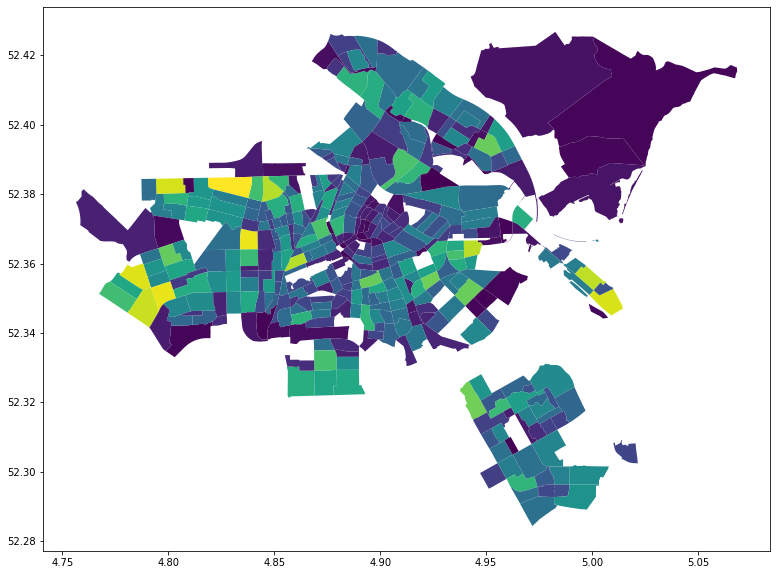

In [ ]:
### statisch plaatje
amsterdam.plot('AANT_INW', figsize=(20, 10))

In [ ]:
### interactive plaatje met folium
m = amsterdam.explore(
    column = 'AANT_INW',
    tooltip= ['BU_NAAM', 'BEV_DICHTH', 'AANT_INW'],
    width = 700,
    height = 600
)
m

Output hidden; open in https://colab.research.google.com to view.

## Punten om op bovenstaande map te zetten. 
Neem de lijst met locaties van parkeergarages in Amsterdam, is open data

In [ ]:
!wget -O parkeer_locaties.json https://api.data.amsterdam.nl/dcatd/datasets/KcbuTzpG6yRHvg/purls/KluYGmQQ2p5Yqw

In [ ]:
with open('parkeer_locaties.json') as json_file:
    parkeer_locaties = json.load(json_file)

In [ ]:
### we hebben nu een dict met parkeer locaties
parkeer_locaties['parkeerlocaties'][0:4]

[{'parkeerlocatie': {'Locatie': '{"type":"Point","coordinates":[4.9032801,52.3824545]}',
   'adres': 'Buiksloterweg 3',
   'opmerkingen': 'Alleen toegankelijk voor abonnementhouders van Tolhuisplein, automatische stalling',
   'postcode': '1031 CC',
   'title': 'Fietsenstalling Tolhuisplein',
   'type': 'Fietspunt',
   'url': 'https://www.amsterdam.nl/parkeren-verkeer/fiets/fietsparkeren/gemeentelijke/',
   'urltitle': 'www.amsterdam.nl/fiets',
   'woonplaats': 'Amsterdam'}},
 {'parkeerlocatie': {'Locatie': '{"type":"Point","coordinates":[4.8833735,52.3621851]}',
   'adres': 'Weteringschans 4 A',
   'opmerkingen': 'Maximale parkeerduur 28 dagen, stalling met toezicht',
   'postcode': '1017 SG',
   'title': 'Fietsenstalling Paradiso',
   'type': 'Fietspunt',
   'url': 'https://www.amsterdam.nl/parkeren-verkeer/fiets/fietsparkeren/gemeentelijke/',
   'urltitle': 'www.amsterdam.nl/fiets',
   'woonplaats': 'Amsterdam'}},
 {'parkeerlocatie': {'Locatie': '{"type":"Point","coordinates":[4.871

In [ ]:
#### use json_normalize to get each location into a row in a pandas dataframe
parkeer_locaties_df = pd.json_normalize(parkeer_locaties['parkeerlocaties'])
parkeer_locaties_df.columns = parkeer_locaties_df.columns.str.replace('.', '_')

In [ ]:
parkeer_locaties_df.sample(4)

,parkeerlocatie_title,parkeerlocatie_Locatie,parkeerlocatie_type,parkeerlocatie_url,parkeerlocatie_urltitle,parkeerlocatie_adres,parkeerlocatie_postcode,parkeerlocatie_woonplaats,parkeerlocatie_opmerkingen,parkeerlocatie_OV_bus,parkeerlocatie_OV_tram,parkeerlocatie_OV,parkeerlocatie_OV_metro,parkeerlocatie_OV_trein,parkeerlocatie_aantal
11,P18 HES/ ROC,"{""type"":""Point"",""coordinates"":[4.9466199,52.31...",Parkeergarage,https://www.amsterdam.nl/parkeren-verkeer/park...,Bekijk P18 HES/ ROC op www.amsterdam.nl/parkee...,Fraijlemaborg 131,1102CV,Amsterdam,,NaN,NaN,NaN,NaN,NaN,NaN
85,P+R Noord,"{""type"":""Point"",""coordinates"":[4.9343041,52.40...",P+R,https://www.amsterdam.nl/parkeren-verkeer/park...,Meer informatie over de stations langs de nieu...,Nieuwe Leeuwarderweg 25,1022BP,Amsterdam,Afslag S116 vanaf de A10,bus 37 Noord - Amstelstation vv,NaN,"metro;GVB_52_1;09571;09581, bus;GVB_37_2;01316",metro 52 Noord - Zuid vv,NaN,NaN
98,Boven 't Y,"{""type"":""Point"",""coordinates"":[4.9388323,52.39...",P+R,https://www.amsterdam.nl/parkeren-verkeer/park...,P+R Boven 't Y,Buikslotermeerplein 237,1025 XB,Amsterdam,Vanaf A10: afrit S116,bus 37 Noord - Amstelstation vv,NaN,NaN,metro 52 Noord - Zuid vv,NaN,200
37,P6 Pathé ArenA,"{""type"":""Point"",""coordinates"":[4.9455507,52.31...",Parkeergarage,https://www.amsterdam.nl/parkeren-verkeer/park...,Bekijk P6 Pathé ArenA op www.amsterdam.nl/park...,De corridor 15,1101BC,Amsterdam,,NaN,NaN,NaN,NaN,NaN,NaN


We moeten de long lat uit de parkeer_Locatie kolom halen en dat als POINT in een geopandas data frame zetten

In [ ]:
##json.loads(parkeer_locaties_df['parkeerlocatie_Locatie'][0])['coordinates']

[4.9032801, 52.3824545]

In [ ]:
parkeer_locaties_df ['lon'], parkeer_locaties_df[ 'lat'] = zip( *parkeer_locaties_df.parkeerlocatie_Locatie.apply(lambda x : json.loads(x)['coordinates']))
parkeer_locaties_df = gpd.GeoDataFrame(parkeer_locaties_df, geometry= gpd.points_from_xy(parkeer_locaties_df ['lon'], parkeer_locaties_df[ 'lat']))

In [ ]:
parkeer_locaties_df

,parkeerlocatie_title,parkeerlocatie_Locatie,parkeerlocatie_type,parkeerlocatie_url,parkeerlocatie_urltitle,parkeerlocatie_adres,parkeerlocatie_postcode,parkeerlocatie_woonplaats,parkeerlocatie_opmerkingen,parkeerlocatie_OV_bus,parkeerlocatie_OV_tram,parkeerlocatie_OV,parkeerlocatie_OV_metro,parkeerlocatie_OV_trein,parkeerlocatie_aantal,lon,lat,geometry
0,Fietsenstalling Tolhuisplein,"{""type"":""Point"",""coordinates"":[4.9032801,52.38...",Fietspunt,https://www.amsterdam.nl/parkeren-verkeer/fiet...,www.amsterdam.nl/fiets,Buiksloterweg 3,1031 CC,Amsterdam,Alleen toegankelijk voor abonnementhouders van...,NaN,NaN,NaN,NaN,NaN,NaN,4.903280,52.382455,POINT (4.90328 52.38245)
1,Fietsenstalling Paradiso,"{""type"":""Point"",""coordinates"":[4.8833735,52.36...",Fietspunt,https://www.amsterdam.nl/parkeren-verkeer/fiet...,www.amsterdam.nl/fiets,Weteringschans 4 A,1017 SG,Amsterdam,"Maximale parkeerduur 28 dagen, stalling met to...",NaN,NaN,NaN,NaN,NaN,NaN,4.883374,52.362185,POINT (4.88337 52.36219)
2,Fietsenstalling Zuidplein,"{""type"":""Point"",""coordinates"":[4.8719467,52.33...",Fietspunt,https://www.amsterdam.nl/parkeren-verkeer/fiet...,www.amsterdam.nl/fiets,Zuidplein 5,1077 XV,Amsterdam,"Maximale parkeerduur 28 dagen, stalling met to...",NaN,NaN,NaN,NaN,NaN,NaN,4.871947,52.339864,POINT (4.87195 52.33986)
3,Fietsenstalling Station Rai (gesloten tot febr...,"{""type"":""Point"",""coordinates"":[4.8905079,52.33...",Fietspunt,https://www.amsterdam.nl/parkeren-verkeer/fiet...,www.amsterdam.nl/fiets,Europaboulevard 4,1083 AD,Amsterdam,Sluit voor renovatie op 21 juli 2018. Er zijn ...,NaN,NaN,NaN,NaN,NaN,NaN,4.890508,52.339392,POINT (4.89051 52.33939)
4,P+R Zeeburg I en II,"{""type"":""Point"",""coordinates"":[4.9607015,52.37...",P+R,https://www.amsterdam.nl/parkeren-verkeer/park...,www.amsterdam.nl/penr,Zuiderzeeweg 46 a,1095KJ,Amsterdam,,bus 37 Noord - Amstelstation vv,tram 26 Ijburg - Centraal Station vv,"tram;GVB_26_1;08240, bus;GVB_37_2;08134",NaN,NaN,NaN,4.960701,52.371963,POINT (4.96070 52.37196)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Haardstee,"{""type"":""Point"",""coordinates"":[4.9522569,52.31...",Parkeergarage,https://www.amsterdam.nl/parkeren-verkeer/park...,Parkeergarage Haardstee,Haardstee 100,1102NE,Amsterdam,,NaN,NaN,NaN,NaN,NaN,NaN,4.952257,52.311210,POINT (4.95226 52.31121)
95,Hoptille,"{""type"":""Point"",""coordinates"":[4.9547267,52.30...",Parkeergarage,https://www.amsterdam.nl/parkeren-verkeer/park...,Parkeergarage Hoptille,Hoptille 100,1102PR,Amsterdam,,NaN,NaN,NaN,NaN,NaN,NaN,4.954727,52.309071,POINT (4.95473 52.30907)
96,Fietsenstalling Rokin,"{""type"":""Point"",""coordinates"":[4.8921686,52.36...",Fietspunt,https://www.amsterdam.nl/parkeren-verkeer/fiet...,www.amsterdam.nl/fiets,Rokin 127,1012 LC,Amsterdam,,NaN,NaN,NaN,NaN,NaN,NaN,4.892169,52.369219,POINT (4.89217 52.36922)
97,P+R Zeeburg III,"{""type"":""Point"",""coordinates"":[4.9723682,52.36...",P+R,https://www.amsterdam.nl/parkeren-verkeer/park...,www.amsterdam.nl/penr,Marie Baronlaan,1095 MV,Amsterdam,,bus 37 Noord - Amstelstation vv,tram 26 Ijburg - Centraal Station vv,tram;GVB_26_1;08009,NaN,NaN,265,4.972368,52.369987,POINT (4.97237 52.36999)


### Splitsting in fiets en auto parkeergarages

Zie voor icoontjes die je op de markers kunt gebruiken:
https://fontawesome.com/v5.15/icons?d=gallery&p=2

In [ ]:
Fietspunt = parkeer_locaties_df.query("parkeerlocatie_type == 'Fietspunt'")
Autos = parkeer_locaties_df.query("parkeerlocatie_type != 'Fietspunt'")


In [ ]:
## Kaart met buurt shapes en parkeerlocaties 

### maak interactive kaart met buurtshapes
m = amsterdam.explore(
    column = 'AANT_INW',
    tooltip = ['BU_NAAM', 'BEV_DICHTH', 'AANT_INW'],
    width =  1000,
    height = 800
)

### Zet fiets parkeergarages er op
m2 = Fietspunt.explore(
  m = m, 
  marker_type ='marker', 
  marker_kwds = dict( icon=folium.Icon(color="green", icon ="bicycle", prefix='fa')), 
  tooltip = "parkeerlocatie_title",
  tooltip_kwds = dict(labels=True), 
  name = "parkeerlocatie_title", 
  popup = ['parkeerlocatie_title', 'parkeerlocatie_type']
)

### Zet auto parkeergarages er op
m3 = Autos.explore(
  m = m2, 
  marker_type ='marker', 
  marker_kwds = dict( icon=folium.Icon(color="red",  icon ="car", prefix='fa')), 
  tooltip = "parkeerlocatie_title",
  tooltip_kwds = dict(labels=True), 
  name = "parkeerlocatie_title", 
  popup = ['parkeerlocatie_title', 'parkeerlocatie_type']
)

m3

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#### kaartje kan bewaard worden.
m3.save(outfile= "amsterdam_parkeergarages.html")

output file is een html file die je op een website ergens kan zetten

https://longhowlam.github.io/amsterdam_parking.html

# parkeer vakken amsterdam

alle parkeervakken zijn te downloaden als geojson, en met read_file in geopandas kan je in een keer dat in een geopandas file krijgen. Hier zouden we per buurt het aantal parkeervakken kunnen tellen en vergelijken met aantal inwoners en dat op een polygon kaartje zetten te samen met de parkeer garages

In [ ]:
url = "https://map.data.amsterdam.nl/maps/parkeervakken?REQUEST=Getfeature&VERSION=1.1.0&SERVICE=wfs&TYPENAME=alle_parkeervakken&outputformat=geojson"
adam_pvakken = gpd.read_file(url)

Er zijn iets van 273K parkeerplekken in Amsterdam

In [ ]:
adam_pvakken

,id,buurtcode,straatnaam,type,soort,e_type,aantal,geometry
0,129656479983,T98a,Zonnehof,Haaks,NIET FISCA,,1.0,"POLYGON ((129656.220 479986.130, 129658.490 47..."
1,129658479984,T98a,Zonnehof,Haaks,NIET FISCA,,1.0,"POLYGON ((129658.800 479987.430, 129658.700 47..."
2,129654479994,T98a,Zonnehof,Haaks,NIET FISCA,,1.0,"POLYGON ((129651.470 479995.520, 129653.590 47..."
3,129649479992,T98a,Zonnehof,Haaks,NIET FISCA,,1.0,"POLYGON ((129649.360 479994.440, 129651.640 47..."
4,129652479993,T98a,Zonnehof,Haaks,NIET FISCA,,1.0,"POLYGON ((129651.470 479995.520, 129653.750 47..."
...,...,...,...,...,...,...,...,...
273548,120601487207,A06g,Lauriergracht,Langs,FISCAAL,,1.0,"POLYGON ((120604.070 487207.580, 120598.650 48..."
273549,120606487210,A06g,Lauriergracht,Langs,FISCAAL,,1.0,"POLYGON ((120610.050 487210.070, 120604.070 48..."
273550,120833487513,A02b,Keizersgracht,Langs,FISCAAL,,1.0,"POLYGON ((120833.830 487516.350, 120835.360 48..."
273551,120836487519,A02b,Keizersgracht,Langs,FISCAAL,,1.0,"POLYGON ((120838.330 487520.680, 120835.360 48..."


In [ ]:
straten = adam_pvakken.straatnaam.value_counts().to_frame()
straten

,straatnaam
ONBEKEND,15861
Buikslotermeerplein,1411
Keizersgracht,916
Kantershof,887
Het Breed,835
...,...
A. Eversplein,1
Centrale Groothandelsmarkt,1
Liendenhof,1
Overslaghof,1


In [ ]:
Keizersgracht = adam_pvakken.query("straatnaam == 'Keizersgracht'")

In [ ]:
Keizersgracht.explore()

In [ ]:
## reken aantal parkeervakken uit per buurt

per_buurt = (
    adam_pvakken
    .groupby('buurtcode', as_index = False)
    .agg(aantal_parkeervakken=('aantal', 'sum'))
)
per_buurt.sample(3)

,buurtcode,aantal_parkeervakken
308,M33d,367.0
94,E15b,66.0
222,K25a,407.0


In [ ]:
### We hebben een koppel tabel nodig tussen buurt codes en CBS buurtnamen
### deze kunnen we hier vinden. We zien een amsterdamse buurt code en een cbsCode
amsterdam_codes_naam = pd.read_csv('https://api.data.amsterdam.nl/dcatd/datasets/5L2CSm77FLZGYA/purls/12', sep = ';')

In [ ]:
amsterdam_codes_naam.sample(3)

,identificatie,code,naam,beginGeldigheid,eindGeldigheid,documentdatum,documentnummer,cbsCode,ligtIn:GBD.WIJK.identificatie,ligtIn:GBD.WIJK.code,ligtIn:GBD.WIJK.naam,ligtIn:GBD.GGW.identificatie,ligtIn:GBD.GGW.code,ligtIn:GBD.GGW.naam,ligtIn:GBD.GGP.identificatie,ligtIn:GBD.GGP.code,ligtIn:GBD.GGP.naam,ligtIn:GBD.SDL.identificatie,ligtIn:GBD.SDL.code,ligtIn:GBD.SDL.naam,ligtIn:BRK.GME.identificatie,ligtIn:BRK.GME.naam,geometrie
239,3630000000804,K46b,Valeriusbuurt West,2010-05-01,NaN,2009-06-19,raadsbesluit 116/292,BU03634601,3630012052053,K46,Willemspark,3.630950e+12,DX10,Oud-Zuid,3.630940e+12,PX14,Oud-Zuid,3630011872038,K,Zuid,363,Amsterdam,"POLYGON ((119319.202 485167.996, 119304.685 48..."
225,3630000000790,K25c,Lizzy Ansinghbuurt,2010-05-01,NaN,2009-06-19,raadsbesluit 116/292,BU03632502,3630012052060,K25,Nieuwe Pijp,3.630950e+12,DX12,"De Pijp, Rivierenbuurt",3.630940e+12,PX13,"De Pijp, Rivierenbuurt",3630011872038,K,Zuid,363,Amsterdam,"POLYGON ((121447.189 484937.872, 121449.07 484..."
287,3630000000855,K91c,Buitenveldert Zuidoost,2010-05-01,NaN,2009-06-19,raadsbesluit 116/292,BU03639102,3630012052003,K91,Buitenveldert-Oost,3.630950e+12,DX11,"Buitenveldert, Zuidas",3.630940e+12,PX12,"Buitenveldert, Zuidas",3630011872038,K,Zuid,363,Amsterdam,"POLYGON ((121106.124 482500.747, 120389.791 48..."


In [ ]:
per_buurt_info = (
    per_buurt
    .merge(
        amsterdam_codes_naam [['code', 'naam','cbsCode']],
        how = 'left',
        left_on = 'buurtcode',
        right_on = 'code'
    )
     .dropna(subset = ['code'])
   
)
per_buurt_info_cbs = (
    amsterdam
    .merge(
        per_buurt_info,
        right_on = 'cbsCode',
        left_on = 'BU_CODE'
    )
)

per_buurt_info_cbs = (
    per_buurt_info_cbs
    .assign(parkeer_dichtheid = per_buurt_info_cbs.aantal_parkeervakken / per_buurt_info_cbs.AANT_INW )
)


per_buurt_info_cbs.sample(5)

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_ONGEHUWD,P_GEHUWD,P_GESCHEID,P_VERWEDUW,AANTAL_HH,P_EENP_HH,P_HH_Z_K,P_HH_M_K,GEM_HH_GR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry,buurtcode,aantal_parkeervakken,code,naam,cbsCode,parkeer_dichtheid
323,BU03638502,Jacob Geelbuurt,WK036385,GM0363,Amsterdam,1,NEE,1065,1,4555,1,10862,3355,1705,1650,21,15,35,20,8,63,26,9,2,1560,46,19,35,2.1,14,65,29,0,6,15,15,32,31,1,2021BU03638502,2021,2355.294762,321483.258070,"POLYGON ((4.83388 52.36367, 4.83390 52.36246, ...",F85c,1272.0,F85c,Jacob Geelbuurt,BU03638502,0.379136
210,BU03635207,Kop Zuidas,WK036352,GM0363,Amsterdam,1,NEE,1079,1,3833,1,4113,680,350,330,13,5,62,12,9,65,28,5,2,350,36,44,20,1.9,31,18,1,0,0,3,13,17,17,0,2021BU03635207,2021,2157.926530,169382.045426,"POLYGON ((4.89413 52.34076, 4.89443 52.34075, ...",K52h,53.0,K52h,Kop Zuidas,BU03635207,0.077941
331,BU03638701,Andreasterrein,WK036387,GM0363,Amsterdam,1,NEE,1058,1,7754,1,8670,1250,615,630,20,9,37,23,11,59,32,7,2,555,37,26,37,2.2,24,37,14,0,4,6,12,18,14,3,2021BU03638701,2021,2184.558150,177424.245315,"POLYGON ((4.84889 52.35791, 4.84889 52.35780, ...",F87b,131.0,F87b,Andreasterrein,BU03638701,0.104800
220,BU03635505,Tuindorp Amstelstation,WK036355,GM0363,Amsterdam,1,NEE,1097,1,4904,1,7659,830,360,470,15,10,23,29,24,58,20,16,6,485,55,16,29,1.7,12,44,11,0,11,4,17,11,11,0,2021BU03635505,2021,1362.023207,110045.641639,"POLYGON ((4.92558 52.34566, 4.92607 52.34536, ...",M55f,360.0,M55f,Tuindorp Amstelstation,BU03635505,0.433735
304,BU03637804,Eendrachtspark,WK036378,GM0363,Amsterdam,1,NEE,1067,1,2155,2,2475,300,175,125,13,9,43,30,5,66,26,7,1,165,63,18,19,1.7,17,52,10,0,9,22,11,14,12,2,2021BU03637804,2021,1606.056846,140127.420636,"POLYGON ((4.81216 52.38056, 4.81009 52.38053, ...",F78e,122.0,F78e,Eendrachtspark,BU03637804,0.406667


In [ ]:
#####  er zijn wat rare outliers op parkeer_dichtheid
px.histogram(per_buurt_info_cbs, x = 'parkeer_dichtheid')

In [ ]:
per_buurt_info_cbs.query('parkeer_dichtheid > .81')[['BU_NAAM', 'AANT_INW', 'aantal_parkeervakken', 'parkeer_dichtheid']]

,BU_NAAM,AANT_INW,aantal_parkeervakken,parkeer_dichtheid
64,Teleport,695,645.0,0.928058
147,Bedrijventerrein Landlust,540,481.0,0.890741
177,Bedrijventerrein Schinkel,260,1350.0,5.192308
197,Diepenbrockbuurt,805,766.0,0.951553
227,Sportpark Middenmeer Zuid,295,245.0,0.830508
236,Prinses Irenebuurt,1380,1160.0,0.840580
252,Oostzanerdijk,400,368.0,0.920000
265,Rode Kruisbuurt,230,293.0,1.273913
267,Buikslotermeerplein,985,1362.0,1.382741
277,Papaverweg e.o.,1295,1412.0,1.090347


In [ ]:
## Kaart met buurt shapes, met parkeerdichtheid  en parkeerlocaties 

### maak interactive kaart met buurtshapes
m = (
    per_buurt_info_cbs
    .query('parkeer_dichtheid <= .75')
    .explore(
    column = 'parkeer_dichtheid',
    tooltip = ['BU_NAAM', 'aantal_parkeervakken', 'AANT_INW', 'parkeer_dichtheid'],
    width =  1000,
    height = 800
  )
)

### Zet fiets parkeergarages er op
m2 = Fietspunt.explore(
  m = m, 
  marker_type ='marker', 
  marker_kwds = dict( icon=folium.Icon(color="green", icon ="bicycle", prefix='fa')), 
  tooltip = "parkeerlocatie_title",
  tooltip_kwds = dict(labels=True), 
  name = "parkeerlocatie_title", 
  popup = ['parkeerlocatie_title', 'parkeerlocatie_type']
)

### Zet auto parkeergarages er op
m3 = Autos.explore(
  m = m2, 
  marker_type ='marker', 
  marker_kwds = dict( icon=folium.Icon(color="red",  icon ="car", prefix='fa')), 
  tooltip = "parkeerlocatie_title",
  tooltip_kwds = dict(labels=True), 
  name = "parkeerlocatie_title", 
  popup = ['parkeerlocatie_title', 'parkeerlocatie_type']
)

m3

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
m3.save(outfile= "amsterdam_parkeerdichtheid_en_garages.html")